In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os

# Dezactivarea W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare the dataset
texts = []
labels = []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True)

train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Convert labels to torch tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Load the pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(bloom_categories))

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model checkpoints
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"      # evaluate after each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids)  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(X_test, y_test)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.160100,1.091795,0.828283,0.706897
2,0.920000,0.890084,0.828283,0.706897
3,0.753600,0.834912,0.828283,0.706897


Evaluation Results: {'eval_loss': 0.8349121809005737, 'eval_f1': 0.8282828282828283, 'eval_accuracy': 0.7068965517241379, 'eval_runtime': 5.2768, 'eval_samples_per_second': 32.974, 'eval_steps_per_second': 0.569, 'epoch': 3.0}
Faulty predictions saved to faulty_predictions.json


In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
import os

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"qg_agno_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare the dataset
texts = []
labels = []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("hadifar/openstax_qg_agno")
model = AutoModelForSeq2SeqLM.from_pretrained("hadifar/openstax_qg_agno")

# Tokenize the dataset
def tokenize_function(examples):
    # Returning tensors directly for the required input format
    return tokenizer(examples, padding='max_length', truncation=True, max_length=512, return_tensors="pt")

train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Convert labels to torch tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model checkpoints
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"      # evaluate after each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids)  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions_output = trainer.predict(test_dataset)
predicted_labels = predictions_output.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(X_test, y_test)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=bloom_categories, yticklabels=bloom_categories)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png")
plt.show()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer
import os

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"qg_agno_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare the dataset
texts = []
labels = []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("hadifar/openstax_qg_agno")
model = AutoModelForSeq2SeqLM.from_pretrained("hadifar/openstax_qg_agno")

# Tokenize the dataset
def tokenize_function(examples):
    encodings = tokenizer(examples, truncation=True, padding="max_length", max_length=512, return_tensors="pt")
    return encodings

train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Convert labels to torch tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory for model checkpoints
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch"      # evaluate after each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids)  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(X_test, y_test)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=bloom_categories, yticklabels=bloom_categories)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png")
plt.show()


tokenizer_config.json:   0%|          | 0.00/2.16k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


ValueError: not enough values to unpack (expected 2, got 1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.042000,1.433742,0.082873,0.031361
2,2.379800,1.131478,0.723757,0.607770
3,1.888800,0.896567,0.723757,0.607770
4,1.570600,0.831505,0.723757,0.607770


Evaluation Results: {'eval_loss': 0.8315049409866333, 'eval_accuracy': 0.7237569060773481, 'eval_f1': 0.6077702224111065, 'eval_runtime': 0.5779, 'eval_samples_per_second': 313.195, 'eval_steps_per_second': 20.764, 'epoch': 4.9010989010989015}
Faulty predictions saved to faulty_predictions.json


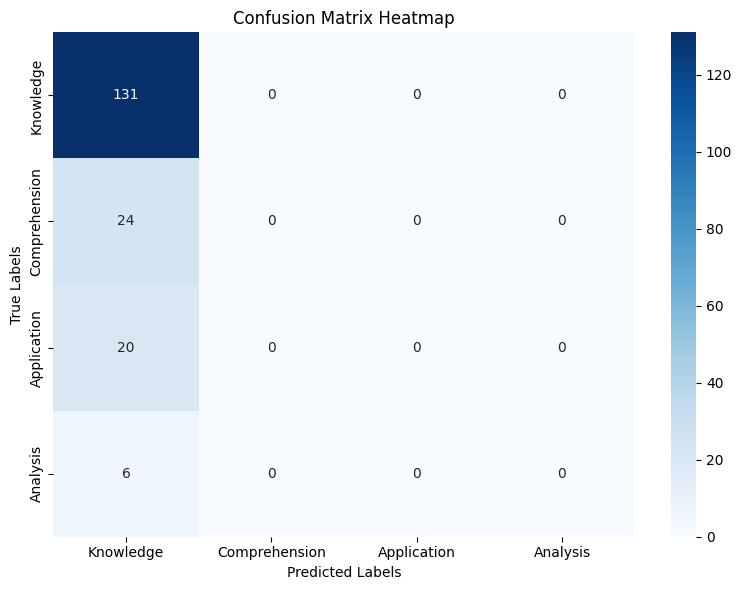

In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import os
import numpy as np

# Disable W&B (Weights and Biases)
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your datasets
dataset_paths = [r"eduqg_evaluation_bloom_cleaned.json", r"eduqg_few_shot_bloom_cleaned.json"]
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load and combine datasets
texts = []
labels = []

for dataset_path in dataset_paths:
    with open(dataset_path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
        for chapter in dataset:
            for question_item in chapter.get('questions', []):
                question = question_item.get("question", {}).get("normal_format", "")
                actual_bloom = question_item.get("actual_bloom", "")
                if question and actual_bloom:
                    texts.append(question)
                    labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Split the combined dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True, max_length=128)

train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Convert labels to torch tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Load the pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(bloom_categories))

# Metrics for evaluation
def compute_metrics(p):
    preds = p.predictions.argmax(axis=-1)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    accuracy = accuracy_score(p.label_ids, preds)
    return {"accuracy": accuracy, "f1": f1}

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',               # output directory for model checkpoints
    num_train_epochs=5,                   # increased number of training epochs
    per_device_train_batch_size=8,        # smaller batch size for finer gradients
    per_device_eval_batch_size=16,        # batch size for evaluation
    warmup_steps=200,                     # number of warmup steps for LR scheduler
    weight_decay=0.01,                    # strength of weight decay
    logging_dir='./logs',                 # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",          # evaluate after each epoch
    save_strategy="epoch",                # save model after each epoch
    save_total_limit=3,                   # limit the number of saved models
    learning_rate=5e-6,                   # reduced learning rate for finer tuning
    load_best_model_at_end=True,          # load the best model at the end of training
    gradient_accumulation_steps=2,        # simulate a larger effective batch size
    lr_scheduler_type="cosine",           # cosine annealing for learning rate
    seed=42
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,     # custom metrics
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping for optimization
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(X_test, y_test)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=bloom_categories, yticklabels=bloom_categories)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.savefig("confusion_matrix_heatmap.png")
plt.show()


In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import os

# Disable W&B (Weights and Biases)
os.environ["WANDB_DISABLED"] = "true"

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)

# Define the paths for your dataset
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare the dataset
texts = []
labels = []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=SEED)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True, max_length=128)

train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Convert labels to torch tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Load the pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(bloom_categories))

# Metrics for evaluation
def compute_metrics(p):
    preds = p.predictions.argmax(axis=-1)
    f1 = f1_score(p.label_ids, preds, average='weighted')
    accuracy = accuracy_score(p.label_ids, preds)
    return {"accuracy": accuracy, "f1": f1}

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',              # output directory for model checkpoints
    num_train_epochs=10,                 # increased number of training epochs
    per_device_train_batch_size=8,       # smaller batch size for finer gradients
    per_device_eval_batch_size=16,
    warmup_steps=200,                    # number of warmup steps for LR scheduler
    weight_decay=0.01,                   # strength of weight decay
    logging_dir='./logs',                # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",         # evaluate after each epoch
    save_strategy="epoch",               # save model after each epoch
    save_total_limit=3,                  # limit the number of saved models
    learning_rate=5e-6,                  # reduced learning rate for finer tuning
    load_best_model_at_end=True,         # load the best model at the end of training
    gradient_accumulation_steps=2,       # simulate a larger effective batch size
    lr_scheduler_type="cosine",          # cosine annealing for learning rate
    seed=SEED
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=compute_metrics,     # custom metrics
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # Early stopping for optimization
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(X_test, y_test)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,2.778200,1.303225,0.643678,0.565832
2,2.174700,1.070416,0.706897,0.585510
3,1.886200,0.953254,0.706897,0.585510
4,1.557900,0.881337,0.706897,0.585510
5,1.519100,0.852489,0.706897,0.585510
6,1.564500,0.811017,0.706897,0.585510
7,1.483800,0.795640,0.706897,0.585510
8,1.398500,0.788455,0.706897,0.587488
9,1.111300,0.782936,0.706897,0.589480


Evaluation Results: {'eval_loss': 0.7823790907859802, 'eval_accuracy': 0.7126436781609196, 'eval_f1': 0.6017900620414635, 'eval_runtime': 0.5447, 'eval_samples_per_second': 319.417, 'eval_steps_per_second': 20.193, 'epoch': 9.781609195402298}
Faulty predictions saved to faulty_predictions.json


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Dezactivarea W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare the dataset
texts = []
labels = []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True)

train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Convert labels to torch tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Load the pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(bloom_categories))

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',           # output directory for model checkpoints
    num_train_epochs=5,               # number of training epochs
    per_device_train_batch_size=8,    # reduced batch size for better memory handling
    per_device_eval_batch_size=16,    # batch size for evaluation
    warmup_steps=1000,                # increased number of warmup steps
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',             # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",      # evaluate after each epoch
    save_strategy="epoch",            # save checkpoint after each epoch
    load_best_model_at_end=True,      # load best model after training
    learning_rate=2e-5,               # reduced learning rate for finer tuning
    gradient_accumulation_steps=2,    # accumulate gradients to simulate a larger batch size
    max_grad_norm=1.0,                # gradient clipping to avoid exploding gradients
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids)  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(X_test, y_test)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,2.821800,1.365903,0.055950,0.034483
2,2.508400,1.167700,0.828283,0.706897
3,1.760900,0.895831,0.828283,0.706897
4,1.484000,0.874715,0.828283,0.706897


KeyboardInterrupt: 

In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare the dataset
texts = []
labels = []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")
        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True)

train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Convert labels to torch tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Load the pre-trained BERT model for classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(bloom_categories))

# Set up training arguments with adjustments
training_args = TrainingArguments(
    output_dir='./results',           # output directory for model checkpoints
    num_train_epochs=5,               # number of training epochs
    per_device_train_batch_size=16,    # increased batch size for better training
    per_device_eval_batch_size=32,    # increased batch size for evaluation
    warmup_steps=1000,                # number of warmup steps
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',             # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",      # evaluate after each epoch
    save_strategy="epoch",            # save checkpoint after each epoch
    load_best_model_at_end=True,      # load best model after training
    learning_rate=3e-5,               # adjusted learning rate for finer tuning
    gradient_accumulation_steps=4,    # accumulate gradients to simulate a larger batch size
    max_grad_norm=1.0,                # gradient clipping to avoid exploding gradients
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids)  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(X_test, y_test)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,6.164200,1.553513,0.195760,0.109195
2,5.932800,1.460768,0.195826,0.114943
3,5.589000,1.305753,0.210021,0.235632
4,5.169200,1.179394,0.723948,0.649425
5,4.732900,1.089345,0.828283,0.706897


Evaluation Results: {'eval_loss': 1.0893452167510986, 'eval_f1': 0.8282828282828283, 'eval_accuracy': 0.7068965517241379, 'eval_runtime': 2.35, 'eval_samples_per_second': 74.043, 'eval_steps_per_second': 2.553, 'epoch': 5.0}
Faulty predictions saved to faulty_predictions.json


In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os

# Dezactivarea W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_large_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare the dataset
texts = []
labels = []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Load the pre-trained BERT tokenizer (for bert-large-uncased)
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples, padding='max_length', truncation=True)

train_encodings = tokenize_function(X_train)
test_encodings = tokenize_function(X_test)

# Convert labels to torch tensors
train_labels = torch.tensor(y_train)
test_labels = torch.tensor(y_test)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Load the pre-trained BERT large model for classification
model = BertForSequenceClassification.from_pretrained('bert-large-uncased', num_labels=len(bloom_categories))

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',           # output directory for model checkpoints
    num_train_epochs=5,               # number of training epochs
    per_device_train_batch_size=8,    # reduced batch size for better memory handling
    per_device_eval_batch_size=16,    # batch size for evaluation
    warmup_steps=1000,                # increased number of warmup steps
    weight_decay=0.01,                # strength of weight decay
    logging_dir='./logs',             # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",      # evaluate after each epoch
    save_strategy="epoch",            # save checkpoint after each epoch
    load_best_model_at_end=True,      # load best model after training
    learning_rate=2e-5,               # reduced learning rate for finer tuning
    gradient_accumulation_steps=2,    # accumulate gradients to simulate a larger batch size
    max_grad_norm=1.0,                # gradient clipping to avoid exploding gradients
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the model to be trained
    args=training_args,                  # training arguments
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset,           # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids)  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(X_test, y_test)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,2.316600,1.113009,0.819587,0.701149
2,1.800400,0.896971,0.828283,0.706897
3,1.494300,0.861812,0.828283,0.706897
4,1.342600,0.818265,0.815536,0.706897


Evaluation Results: {'eval_loss': 0.8182653784751892, 'eval_f1': 0.815536202319773, 'eval_accuracy': 0.7068965517241379, 'eval_runtime': 17.6837, 'eval_samples_per_second': 9.84, 'eval_steps_per_second': 0.622, 'epoch': 4.896551724137931}
Faulty predictions saved to faulty_predictions.json


In [ ]:
import json
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertModel
import numpy as np

# Paths and categories
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
output_model_path = r"bloom_lstm_model"
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare dataset
texts, labels = [], []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")
        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization with BERT tokenizer for word embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Dataset Class
class BloomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = BloomDataset(train_encodings, y_train)
test_dataset = BloomDataset(test_encodings, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# LSTM Model Definition
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, embedding_dim=768, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')  # Use BERT for embeddings
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        # Pass input through BERT to get embeddings
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        embedding_output = outputs.last_hidden_state  # Shape: (batch_size, sequence_length, embedding_dim)

        # LSTM layer
        lstm_out, _ = self.lstm(embedding_output)
        hidden_state = lstm_out[:, -1, :]  # Get the output from the last time step
        output = self.fc(self.dropout(hidden_state))  # Fully connected layer
        return output

# Initialize Model
model = LSTMModel(input_dim=768, hidden_dim=128, output_dim=len(bloom_categories))  # embedding_dim = 768 for BERT
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)  # BERT input
        attention_mask = batch['attention_mask'].to(device)  # Attention mask
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} | Average Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)  # BERT input
            attention_mask = batch['attention_mask'].to(device)  # Attention mask
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    f1 = f1_score(true_labels, predictions, average='weighted')
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation F1 Score: {f1:.4f} | Accuracy: {accuracy:.4f}")

# Save Model
model.save_pretrained(output_model_path)

# Final Evaluation
print("Training Complete.")


Epoch 1 | Average Training Loss: 0.9522
Validation F1 Score: 0.5855 | Accuracy: 0.7069
Epoch 2 | Average Training Loss: 0.8044
Validation F1 Score: 0.5855 | Accuracy: 0.7069
Epoch 3 | Average Training Loss: 0.7948
Validation F1 Score: 0.5855 | Accuracy: 0.7069
Epoch 4 | Average Training Loss: 0.7984
Validation F1 Score: 0.5855 | Accuracy: 0.7069


AttributeError: 'LSTMModel' object has no attribute 'save_pretrained'

In [ ]:
import json
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertModel
import numpy as np

# Paths and categories
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
output_model_path = r"bloom_gru_model"
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare dataset
texts, labels = [], []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")
        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization with BERT tokenizer for word embeddings
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Dataset Class
class BloomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = BloomDataset(train_encodings, y_train)
test_dataset = BloomDataset(test_encodings, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# GRU Model Definition
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, embedding_dim=768, dropout=0.5):
        super(GRUModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')  # Use BERT for embeddings
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        # Pass input through BERT to get embeddings
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        embedding_output = outputs.last_hidden_state  # Shape: (batch_size, sequence_length, embedding_dim)

        # GRU layer
        gru_out, _ = self.gru(embedding_output)
        hidden_state = gru_out[:, -1, :]  # Get the output from the last time step
        output = self.fc(self.dropout(hidden_state))  # Fully connected layer
        return output

# Initialize Model
model = GRUModel(input_dim=768, hidden_dim=128, output_dim=len(bloom_categories))  # embedding_dim = 768 for BERT
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)  # BERT input
        attention_mask = batch['attention_mask'].to(device)  # Attention mask
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} | Average Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)  # BERT input
            attention_mask = batch['attention_mask'].to(device)  # Attention mask
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask)
            preds = torch.argmax(outputs, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    f1 = f1_score(true_labels, predictions, average='weighted')
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation F1 Score: {f1:.4f} | Accuracy: {accuracy:.4f}")

# Save Model
model.save_pretrained(output_model_path)

# Final Evaluation
print("Training Complete.")


Epoch 1 | Average Training Loss: 0.8685
Validation F1 Score: 0.5855 | Accuracy: 0.7069
Epoch 2 | Average Training Loss: 0.8332
Validation F1 Score: 0.5855 | Accuracy: 0.7069
Epoch 3 | Average Training Loss: 0.8296
Validation F1 Score: 0.5855 | Accuracy: 0.7069


KeyboardInterrupt: 

In [ ]:
import json
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np

# Paths and categories
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
output_model_path = r"bloom_bert_model"
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare dataset
texts, labels = [], []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")
        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Dataset Class
class BloomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = BloomDataset(train_encodings, y_train)
test_dataset = BloomDataset(test_encodings, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# BERT Model Definition
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(bloom_categories))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} | Average Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    f1 = f1_score(true_labels, predictions, average='weighted')
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation F1 Score: {f1:.4f} | Accuracy: {accuracy:.4f}")

# Save Model
model.save_pretrained(output_model_path)

# Final Evaluation
print("Training Complete.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Average Training Loss: 0.9682
Validation F1 Score: 0.5855 | Accuracy: 0.7069
Epoch 2 | Average Training Loss: 0.7933
Validation F1 Score: 0.5855 | Accuracy: 0.7069
Epoch 3 | Average Training Loss: 0.7265
Validation F1 Score: 0.5855 | Accuracy: 0.7069
Epoch 4 | Average Training Loss: 0.6210
Validation F1 Score: 0.6502 | Accuracy: 0.7126
Training Complete.


In [ ]:
import json
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
import numpy as np
from nltk.corpus import wordnet
import random

# Paths and categories
dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
output_model_path = r"bloom_bert_augmentation_model"
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the dataset
dataset = []
with open(dataset_path, 'r', encoding='utf-8') as f:
    dataset = json.load(f)

# Prepare dataset with data augmentation
def synonym_augmentation(sentence):
    words = sentence.split()
    new_words = []
    for word in words:
        syns = wordnet.synsets(word)
        if syns:
            new_word = random.choice(syns).lemmas()[0].name()
            new_words.append(new_word)
        else:
            new_words.append(word)
    return " ".join(new_words)

texts, labels = [], []
for chapter in dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")
        if question and actual_bloom:
            texts.append(question)
            labels.append(bloom_categories.index(actual_bloom))
            # Augmenting the data by adding a synonym replacement version
            augmented_text = synonym_augmentation(question)
            texts.append(augmented_text)
            labels.append(bloom_categories.index(actual_bloom))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=128, return_tensors='pt')
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=128, return_tensors='pt')

# Dataset Class
class BloomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = BloomDataset(train_encodings, y_train)
test_dataset = BloomDataset(test_encodings, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# BERT Model Definition
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(bloom_categories))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 4
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1} | Average Training Loss: {avg_loss:.4f}")

    # Validation
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    f1 = f1_score(true_labels, predictions, average='weighted')
    accuracy = accuracy_score(true_labels, predictions)
    print(f"Validation F1 Score: {f1:.4f} | Accuracy: {accuracy:.4f}")

# Save Model
model.save_pretrained(output_model_path)

# Final Evaluation
print("Training Complete.")


LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
!pip install transformers datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [1]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput


# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset (eduqg_evaluation_bloom_cleaned)
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset (eduqg_few_shot_bloom_cleaned)
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute class weights to handle the imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),  # Ensure all categories are considered
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load the pre-trained tokenizer and model (BERT-base-cased)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        # Removed num_labels from CrossEntropyLoss initialization
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights) # This line was modified

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Remove num_items_in_batch from kwargs if present to avoid the error
        kwargs.pop('num_items_in_batch', None)

        # remove labels from super().forward() call as it's already handled in loss_fct
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        # Modify the output to match the expected format by Trainer
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the weighted model
# Pass num_labels explicitly during model initialization
model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights.to(device))  # Move class_weights to device

# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',              # output directory for model checkpoints
    num_train_epochs=3,                  # number of training epochs
    per_device_train_batch_size=16,      # batch size for training
    per_device_eval_batch_size=64,       # batch size for evaluation
    warmup_steps=500,                    # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                   # strength of weight decay
    logging_dir='./logs',                # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",         # evaluate after each epoch
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                          # the model to be trained
    args=training_args,                   # training arguments
    train_dataset=train_dataset,          # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

KeyboardInterrupt: 

the results are: Epoch	Training Loss	Validation Loss	F1	Accuracy
1	1.311800	1.654000	0.237986	0.171429
2	1.409800	1.960426	0.521739	0.428571
3	1.241400	2.085874	0.501192	0.457143
Evaluation Results: {'eval_loss': 2.085873603820801, 'eval_f1': 0.5011918751049186, 'eval_accuracy': 0.45714285714285713, 'eval_runtime': 0.1088, 'eval_samples_per_second': 321.798, 'eval_steps_per_second': 9.194, 'epoch': 3.0}

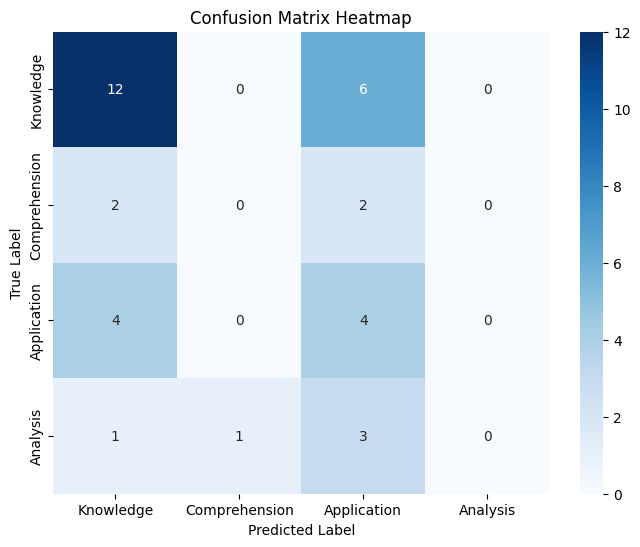

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Generate confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot heatmap of confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=bloom_categories, yticklabels=bloom_categories)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [3]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput


# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset (eduqg_evaluation_bloom_cleaned)
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset (eduqg_few_shot_bloom_cleaned)
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute class weights to handle the imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),  # Ensure all categories are considered
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load the pre-trained tokenizer and model (BERT-base-cased)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        # Removed num_labels from CrossEntropyLoss initialization
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights) # This line was modified

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Remove num_items_in_batch from kwargs if present to avoid the error
        kwargs.pop('num_items_in_batch', None)

        # remove labels from super().forward() call as it's already handled in loss_fct
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        # Modify the output to match the expected format by Trainer
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the weighted model
# Pass num_labels explicitly during model initialization
model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights.to(device))  # Move class_weights to device

# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=5e-5,  # Experiment with a lower learning rate
    lr_scheduler_type="linear",  # Linear decay schedule
)


# Initialize the Trainer
trainer = Trainer(
    model=model,                          # the model to be trained
    args=training_args,                   # training arguments
    train_dataset=train_dataset,          # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WeightedLossModel were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fct.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --re

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.297300,1.816185,0.372093,0.228571
2,1.472300,1.859916,0.346958,0.285714
3,1.230200,2.023634,0.523498,0.457143


Evaluation Results: {'eval_loss': 2.023634195327759, 'eval_f1': 0.5234982882041705, 'eval_accuracy': 0.45714285714285713, 'eval_runtime': 0.1084, 'eval_samples_per_second': 322.992, 'eval_steps_per_second': 9.228, 'epoch': 3.0}
Faulty predictions saved to faulty_predictions.json


In [5]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput


# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset (eduqg_evaluation_bloom_cleaned)
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset (eduqg_few_shot_bloom_cleaned)
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute class weights to handle the imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),  # Ensure all categories are considered
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load the pre-trained tokenizer and model (BERT-base-cased)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        # Removed num_labels from CrossEntropyLoss initialization
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights) # This line was modified

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Remove num_items_in_batch from kwargs if present to avoid the error
        kwargs.pop('num_items_in_batch', None)

        # remove labels from super().forward() call as it's already handled in loss_fct
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        # Modify the output to match the expected format by Trainer
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the weighted model
# Pass num_labels explicitly during model initialization
model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights.to(device))  # Move class_weights to device

# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=5e-5,  # Experiment with a lower learning rate
    lr_scheduler_type="linear",  # Linear decay schedule
)


# Initialize the Trainer
trainer = Trainer(
    model=model,                          # the model to be trained
    args=training_args,                   # training arguments
    train_dataset=train_dataset,          # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WeightedLossModel were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fct.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --re

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.684800,1.180004,0.250000,0.142857
2,1.432900,2.079523,0.323810,0.200000
3,1.238100,2.267164,0.374026,0.342857
4,1.142600,2.243222,0.317302,0.314286
5,0.741100,2.065095,0.376284,0.371429
6,0.618900,2.262473,0.187590,0.200000
7,0.208800,4.205311,0.310476,0.314286
8,0.573300,4.369220,0.347368,0.314286
9,0.126700,5.430581,0.335847,0.314286
10,0.057700,6.398314,0.416105,0.371429


Evaluation Results: {'eval_loss': 6.398313522338867, 'eval_f1': 0.416105303910182, 'eval_accuracy': 0.37142857142857144, 'eval_runtime': 0.1043, 'eval_samples_per_second': 335.731, 'eval_steps_per_second': 9.592, 'epoch': 10.0}
Faulty predictions saved to faulty_predictions.json


In [10]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput


# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset (eduqg_evaluation_bloom_cleaned)
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset (eduqg_few_shot_bloom_cleaned)
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute class weights to handle the imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),  # Ensure all categories are considered
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load the pre-trained tokenizer and model (BERT-base-cased)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        # Removed num_labels from CrossEntropyLoss initialization
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights) # This line was modified

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Remove num_items_in_batch from kwargs if present to avoid the error
        kwargs.pop('num_items_in_batch', None)

        # remove labels from super().forward() call as it's already handled in loss_fct
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        # Modify the output to match the expected format by Trainer
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the weighted model
# Pass num_labels explicitly during model initialization
model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights.to(device))  # Move class_weights to device

# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=5e-5,  # Experiment with a lower learning rate
    lr_scheduler_type="linear",  # Linear decay schedule
)


# Initialize the Trainer
trainer = Trainer(
    model=model,                          # the model to be trained
    args=training_args,                   # training arguments
    train_dataset=train_dataset,          # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WeightedLossModel were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fct.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --re

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.297300,1.816185,0.372093,0.228571
2,1.472300,1.859916,0.346958,0.285714
3,1.230200,2.023634,0.523498,0.457143


Evaluation Results: {'eval_loss': 2.023634195327759, 'eval_f1': 0.5234982882041705, 'eval_accuracy': 0.45714285714285713, 'eval_runtime': 0.1081, 'eval_samples_per_second': 323.892, 'eval_steps_per_second': 9.254, 'epoch': 3.0}
Faulty predictions saved to faulty_predictions.json


In [11]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput


# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset (eduqg_evaluation_bloom_cleaned)
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset (eduqg_few_shot_bloom_cleaned)
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute the class weights using class frequencies in the dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


# Load the pre-trained tokenizer and model (BERT-base-cased)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        # Removed num_labels from CrossEntropyLoss initialization
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights) # This line was modified

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Remove num_items_in_batch from kwargs if present to avoid the error
        kwargs.pop('num_items_in_batch', None)

        # remove labels from super().forward() call as it's already handled in loss_fct
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        # Modify the output to match the expected format by Trainer
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the weighted model
# Pass num_labels explicitly during model initialization
model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights.to(device))  # Move class_weights to device

# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=5e-5,  # Experiment with a lower learning rate
    lr_scheduler_type="linear",  # Linear decay schedule
)


# Initialize the Trainer
trainer = Trainer(
    model=model,                          # the model to be trained
    args=training_args,                   # training arguments
    train_dataset=train_dataset,          # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WeightedLossModel were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fct.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --re

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.297300,1.816185,0.372093,0.228571
2,1.472300,1.859916,0.346958,0.285714
3,1.230200,2.023634,0.523498,0.457143


Evaluation Results: {'eval_loss': 2.023634195327759, 'eval_f1': 0.5234982882041705, 'eval_accuracy': 0.45714285714285713, 'eval_runtime': 0.1081, 'eval_samples_per_second': 323.901, 'eval_steps_per_second': 9.254, 'epoch': 3.0}
Faulty predictions saved to faulty_predictions.json


In [17]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [19]:
!pip install optuna
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput
import optuna  # This is an optional library for hyperparameter tuning

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset (eduqg_evaluation_bloom_cleaned)
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset (eduqg_few_shot_bloom_cleaned)
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute the class weights using class frequencies in the dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load the pre-trained tokenizer and model (BERT-base-cased)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Modify the training_step method in the Trainer class
class CustomTrainer(Trainer):
    def training_step(self, model, inputs, num_items_in_batch=None):
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.
        """
        model.train()
        inputs = self._prepare_inputs(inputs)

        # Remove num_items_in_batch from inputs if present
        if num_items_in_batch is not None and "num_items_in_batch" in inputs:
            del inputs["num_items_in_batch"]

        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        loss.backward()

        return loss.detach()

# Define hyperparameters for training (you can tune these)
def objective(trial):
    # Hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    num_epochs = trial.suggest_int('num_train_epochs', 3, 5)

    # Set up training arguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        lr_scheduler_type="linear",
    )

    # Initialize the weighted model
    model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights)

    # Initialize the Trainer using the CustomTrainer class
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {
            'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
            'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),
        }
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    results = trainer.evaluate()
    return results['eval_f1']  # Return the F1 score as the objective for Optuna optimization

# Use Optuna to optimize hyperparameters
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Adjust the number of trials

print(f"Best trial: {study.best_trial.params}")

# Use best parameters from optimization to retrain the model
best_params = study.best_trial.params
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    lr_scheduler_type="linear",
)

# Initialize the best model
model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights)

# Initialize the Trainer with the best hyperparameters using the CustomTrainer class
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),
    }
)

# Train the model with the best hyperparameters
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-01-18 19:24:53,709] A new study created in memory with name: no-name-09a81f7b-dd7a-47b8-bfd4-75029f26273e
<ipython-input-19-c253acef35a2>:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is dep

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.228400,1.951617,0.635165,0.485714
2,1.241000,2.176317,0.591597,0.457143
3,1.128700,2.065114,0.431897,0.400000
4,0.868100,2.139396,0.245530,0.228571


[I 2025-01-18 19:25:43,608] Trial 0 finished with value: 0.2455299539170507 and parameters: {'learning_rate': 3.238290999182408e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 0 with value: 0.2455299539170507.
<ipython-input-19-c253acef35a2>:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel were

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.378100,1.456800,0.282857,0.257143
2,1.383300,1.461173,0.282857,0.257143
3,1.396600,1.459915,0.246154,0.228571
4,1.409800,1.443561,0.155844,0.171429


[I 2025-01-18 19:26:14,580] Trial 1 finished with value: 0.15584415584415587 and parameters: {'learning_rate': 3.25227371270369e-06, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 0 with value: 0.2455299539170507.
<ipython-input-19-c253acef35a2>:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel wer

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.381000,1.511761,0.591597,0.457143
2,1.290600,1.604418,0.535714,0.428571
3,1.206300,1.863833,0.401088,0.342857
4,1.154100,2.102841,0.485618,0.428571


[I 2025-01-18 19:27:01,763] Trial 2 finished with value: 0.4856177414316949 and parameters: {'learning_rate': 3.889408227085584e-06, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 2 with value: 0.4856177414316949.
<ipython-input-19-c253acef35a2>:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel were

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.378100,1.456197,0.282857,0.257143
2,1.383500,1.458849,0.282857,0.257143
3,1.397800,1.458205,0.282857,0.257143
4,1.413300,1.448921,0.200000,0.200000
5,1.360600,1.453850,0.200000,0.200000


[I 2025-01-18 19:27:39,263] Trial 3 finished with value: 0.2 and parameters: {'learning_rate': 1.9036195313760302e-06, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 2 with value: 0.4856177414316949.
<ipython-input-19-c253acef35a2>:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel were not initiali

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.441000,1.296497,0.247273,0.171429
2,1.444600,1.885324,0.213550,0.257143
3,1.298500,1.914132,0.218776,0.228571
4,1.232000,1.890755,0.291899,0.285714


[I 2025-01-18 19:28:15,725] Trial 4 finished with value: 0.2918985776128633 and parameters: {'learning_rate': 1.326749277086846e-05, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 2 with value: 0.4856177414316949.
<ipython-input-19-c253acef35a2>:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel wer

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.252400,1.907570,0.679245,0.514286
2,1.189600,1.649156,0.370068,0.228571
3,0.942300,2.190430,0.475161,0.428571


[I 2025-01-18 19:28:51,609] Trial 5 finished with value: 0.47516087516087513 and parameters: {'learning_rate': 6.107372199014388e-05, 'batch_size': 8, 'num_train_epochs': 3}. Best is trial 2 with value: 0.4856177414316949.
<ipython-input-19-c253acef35a2>:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel wer

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.354000,1.716452,0.372093,0.228571
2,1.489400,1.937109,0.390204,0.257143
3,1.211700,1.926618,0.336996,0.228571


[I 2025-01-18 19:29:20,370] Trial 6 finished with value: 0.33699633699633696 and parameters: {'learning_rate': 7.735738836233528e-05, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 2 with value: 0.4856177414316949.
<ipython-input-19-c253acef35a2>:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel we

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.418800,1.633629,0.205128,0.114286
2,1.503900,1.624418,0.205128,0.114286
3,1.451000,1.607424,0.205128,0.114286
4,1.431400,1.577338,0.205128,0.114286
5,1.435200,1.555402,0.205128,0.114286


[I 2025-01-18 19:29:58,418] Trial 7 finished with value: 0.20512820512820512 and parameters: {'learning_rate': 2.4077633968676275e-06, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 2 with value: 0.4856177414316949.
<ipython-input-19-c253acef35a2>:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel w

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.446300,1.294529,0.278571,0.200000
2,1.391500,1.666681,0.163265,0.114286
3,1.327400,1.905491,0.234413,0.228571
4,1.304800,1.757256,0.035966,0.057143


[I 2025-01-18 19:30:29,597] Trial 8 finished with value: 0.035966386554621844 and parameters: {'learning_rate': 4.108212195481191e-05, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 2 with value: 0.4856177414316949.
<ipython-input-19-c253acef35a2>:144: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel w

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.398700,1.525687,0.548571,0.428571
2,1.406600,1.655118,0.290598,0.257143
3,1.299200,1.903520,0.295549,0.285714
4,1.160700,1.863903,0.296847,0.228571
5,1.159900,2.269075,0.586494,0.514286


[I 2025-01-18 19:31:14,884] Trial 9 finished with value: 0.5864935064935065 and parameters: {'learning_rate': 2.1177779662998504e-05, 'batch_size': 16, 'num_train_epochs': 5}. Best is trial 9 with value: 0.5864935064935065.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Best trial: {'learning_rate': 2.1177779662998504e-05, 'batch_size': 16, 'num_train_epochs': 5}


Some weights of WeightedLossModel were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fct.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.424800,1.360089,0.162837,0.114286
2,1.489500,1.928713,0.205128,0.114286
3,1.293500,1.809232,0.593407,0.485714
4,1.199600,1.724819,0.672527,0.514286
5,1.308500,1.569131,0.349129,0.314286


Evaluation Results: {'eval_loss': 1.5691314935684204, 'eval_f1': 0.34912891986062716, 'eval_accuracy': 0.3142857142857143, 'eval_runtime': 0.0933, 'eval_samples_per_second': 375.039, 'eval_steps_per_second': 32.146, 'epoch': 5.0}
Faulty predictions saved to faulty_predictions.json


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-01-18 19:34:00,833] A new study created in memory with name: no-name-37eb0e52-e795-4a85-8579-775f33303bd7
<ipython-input-20-82e883ff9092>:139: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is dep

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.311200,1.893057,0.373076,0.257143
2,1.280500,2.032562,0.294678,0.257143
3,0.956500,2.128058,0.293307,0.228571
4,0.933800,2.678944,0.254222,0.200000


[I 2025-01-18 19:34:48,103] Trial 0 finished with value: 0.2542222222222223 and parameters: {'learning_rate': 3.8869219786494705e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 0 with value: 0.2542222222222223.
<ipython-input-20-82e883ff9092>:139: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel wer

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.413400,1.468024,0.288502,0.257143
2,1.402500,1.483370,0.371429,0.314286
3,1.373800,1.507512,0.371429,0.314286
4,1.345000,1.531772,0.359184,0.314286


[I 2025-01-18 19:35:25,314] Trial 1 finished with value: 0.3591836734693878 and parameters: {'learning_rate': 2.4405965058658277e-06, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 1 with value: 0.3591836734693878.
<ipython-input-20-82e883ff9092>:139: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel we

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.378100,1.456886,0.282857,0.257143
2,1.383300,1.461497,0.282857,0.257143
3,1.396400,1.460144,0.246154,0.228571
4,1.409300,1.442733,0.155844,0.171429


[I 2025-01-18 19:35:56,458] Trial 2 finished with value: 0.15584415584415587 and parameters: {'learning_rate': 3.4466599797495684e-06, 'batch_size': 32, 'num_train_epochs': 4}. Best is trial 1 with value: 0.3591836734693878.
<ipython-input-20-82e883ff9092>:139: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel w

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.413700,1.466300,0.288502,0.257143
2,1.402500,1.479826,0.371429,0.314286
3,1.375800,1.500734,0.371429,0.314286


[I 2025-01-18 19:36:25,381] Trial 3 finished with value: 0.37142857142857144 and parameters: {'learning_rate': 2.093612813620588e-06, 'batch_size': 16, 'num_train_epochs': 3}. Best is trial 3 with value: 0.37142857142857144.
<ipython-input-20-82e883ff9092>:139: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel w

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.548300,1.631870,0.205128,0.114286
2,1.477300,1.622399,0.205128,0.114286
3,1.445300,1.605884,0.205128,0.114286
4,1.370000,1.583001,0.205128,0.114286


[I 2025-01-18 19:37:02,430] Trial 4 finished with value: 0.20512820512820512 and parameters: {'learning_rate': 1.385820528433939e-06, 'batch_size': 16, 'num_train_epochs': 4}. Best is trial 3 with value: 0.37142857142857144.
<ipython-input-20-82e883ff9092>:139: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel w

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.377700,1.463583,0.282857,0.257143
2,1.381300,1.481492,0.282857,0.257143
3,1.385300,1.471916,0.236296,0.228571
4,1.368700,1.362737,0.115964,0.114286
5,1.286800,1.513667,0.189648,0.200000


[I 2025-01-18 19:37:40,451] Trial 5 finished with value: 0.189648033126294 and parameters: {'learning_rate': 1.8797485342549577e-05, 'batch_size': 32, 'num_train_epochs': 5}. Best is trial 3 with value: 0.37142857142857144.
<ipython-input-20-82e883ff9092>:139: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel we

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.268500,1.892135,0.133687,0.114286
2,1.291600,1.989555,0.621714,0.485714
3,1.140200,2.064756,0.637299,0.514286
4,1.023500,2.155448,0.672527,0.514286


[I 2025-01-18 19:38:27,817] Trial 6 finished with value: 0.6725274725274725 and parameters: {'learning_rate': 1.365083723480555e-05, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 6 with value: 0.6725274725274725.
<ipython-input-20-82e883ff9092>:139: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel were

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.362600,1.557821,0.679245,0.514286
2,1.259400,1.733681,0.352137,0.314286
3,1.084700,2.207338,0.513623,0.428571


[I 2025-01-18 19:39:04,171] Trial 7 finished with value: 0.5136231884057971 and parameters: {'learning_rate': 8.826880675023355e-06, 'batch_size': 8, 'num_train_epochs': 3}. Best is trial 6 with value: 0.6725274725274725.
<ipython-input-20-82e883ff9092>:139: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel were

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.413700,1.607571,0.205128,0.114286
2,1.256500,1.823038,0.415782,0.400000
3,1.113000,2.070593,0.378378,0.342857
4,0.982100,2.116323,0.485618,0.428571


[I 2025-01-18 19:39:51,502] Trial 8 finished with value: 0.4856177414316949 and parameters: {'learning_rate': 9.103868534318688e-06, 'batch_size': 8, 'num_train_epochs': 4}. Best is trial 6 with value: 0.6725274725274725.
<ipython-input-20-82e883ff9092>:139: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of WeightedLossModel were

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.393000,1.480325,0.411429,0.342857
2,1.309200,1.521046,0.542274,0.428571
3,1.287500,1.593006,0.548571,0.428571
4,1.309900,1.686940,0.635165,0.485714
5,1.201200,1.804353,0.453755,0.371429


[I 2025-01-18 19:40:51,575] Trial 9 finished with value: 0.45375494071146244 and parameters: {'learning_rate': 1.3315540753894772e-06, 'batch_size': 8, 'num_train_epochs': 5}. Best is trial 6 with value: 0.6725274725274725.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Best trial: {'learning_rate': 1.365083723480555e-05, 'batch_size': 8, 'num_train_epochs': 4}


Some weights of WeightedLossModel were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fct.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.268500,1.892135,0.133687,0.114286
2,1.291600,1.989555,0.621714,0.485714
3,1.140200,2.064756,0.637299,0.514286
4,1.023500,2.155448,0.672527,0.514286


Evaluation Results: {'eval_loss': 2.1554479598999023, 'eval_f1': 0.6725274725274725, 'eval_accuracy': 0.5142857142857142, 'eval_runtime': 0.1141, 'eval_samples_per_second': 306.781, 'eval_steps_per_second': 43.826, 'epoch': 4.0}


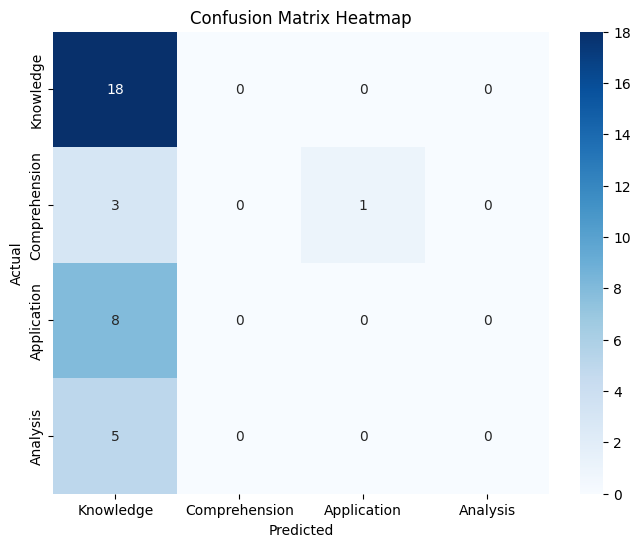

Faulty predictions saved to faulty_predictions.json


In [20]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput
import optuna  # This is an optional library for hyperparameter tuning
import seaborn as sns
import matplotlib.pyplot as plt

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset (eduqg_evaluation_bloom_cleaned)
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset (eduqg_few_shot_bloom_cleaned)
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute the class weights using class frequencies in the dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load the pre-trained tokenizer and model (BERT-base-cased)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Modify the training_step method in the Trainer class
class CustomTrainer(Trainer):
    def training_step(self, model, inputs, num_items_in_batch=None):
        model.train()
        inputs = self._prepare_inputs(inputs)

        if num_items_in_batch is not None and "num_items_in_batch" in inputs:
            del inputs["num_items_in_batch"]

        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        loss.backward()

        return loss.detach()

# Hyperparameter optimization with Optuna
def objective(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32])
    num_epochs = trial.suggest_int('num_train_epochs', 3, 5)

    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        lr_scheduler_type="linear",
    )

    model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights)
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=lambda p: {
            'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
            'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),
        }
    )

    trainer.train()
    results = trainer.evaluate()
    return results['eval_f1']

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

best_params = study.best_trial.params
print(f"Best trial: {study.best_trial.params}")

# Using best hyperparameters to retrain the model
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate'],
    lr_scheduler_type="linear",
)

model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),
    }
)

trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=bloom_categories, yticklabels=bloom_categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Save faulty predictions
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


In [30]:
import json
import torch
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, accuracy_score
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch import nn
import os
import numpy as np

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_t5_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset (eduqg_evaluation_bloom_cleaned)
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset (eduqg_few_shot_bloom_cleaned)
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute the class weights using class frequencies in the dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load the pre-trained tokenizer
tokenizer = T5Tokenizer.from_pretrained("t5-base")

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples, padding=True, truncation=True, max_length=512)

train_encodings = tokenize_function(train_texts)
test_encodings = tokenize_function(test_texts)

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Modify the T5 model for classification
class WeightedLossModel(T5ForConditionalGeneration):
    def __init__(self, config, class_weights, num_labels):
        super().__init__(config)
        self.num_labels = num_labels
        self.class_weights = class_weights

        # Add a classification head
        self.classification_head = nn.Linear(config.d_model, num_labels)

        # Use weighted cross-entropy loss
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Forward pass through the T5 encoder
        encoder_outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        # Average the encoder's output to create a pooled representation
        pooled_output = encoder_outputs.last_hidden_state.mean(dim=1)

        # Pass through the classification head
        logits = self.classification_head(pooled_output)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)

        return (loss, logits)

# Load the modified model
model = WeightedLossModel.from_pretrained(
    "t5-base",
    config=T5ForConditionalGeneration.from_pretrained("t5-base").config,
    class_weights=class_weights,
    num_labels=len(bloom_categories),
)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        'f1': f1_score(p.label_ids, p.predictions.argmax(axis=-1), average='weighted'),
        'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(axis=-1)),
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


Some weights of WeightedLossModel were not initialized from the model checkpoint at t5-base and are newly initialized: ['classification_head.bias', 'classification_head.weight', 'loss_fct.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,2722494075204927098162083583229952.000000,3590955806897106117793909491892224.000000,0.361757,0.428571
2,2813583188823592175369039640526848.000000,3590877197704611496146453397504000.000000,0.361757,0.428571
3,2846341805731169995863776166936576.000000,3590760212370899027710475430264832.000000,0.361757,0.428571


Evaluation Results: {'eval_loss': 3.590760212370899e+33, 'eval_f1': 0.3617571059431524, 'eval_accuracy': 0.42857142857142855, 'eval_runtime': 0.1489, 'eval_samples_per_second': 235.113, 'eval_steps_per_second': 20.153, 'epoch': 3.0}
Faulty predictions saved to faulty_predictions.json


In [ ]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput


# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset (eduqg_evaluation_bloom_cleaned)
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset (eduqg_few_shot_bloom_cleaned)
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute the class weights using class frequencies in the dataset
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


# Load the pre-trained tokenizer and model (BERT-base-cased)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        # Removed num_labels from CrossEntropyLoss initialization
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights) # This line was modified

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Remove num_items_in_batch from kwargs if present to avoid the error
        kwargs.pop('num_items_in_batch', None)

        # remove labels from super().forward() call as it's already handled in loss_fct
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        # Modify the output to match the expected format by Trainer
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the weighted model
# Pass num_labels explicitly during model initialization
model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights.to(device))  # Move class_weights to device

# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=5e-5,  # Experiment with a lower learning rate
    lr_scheduler_type="linear",  # Linear decay schedule
)


# Initialize the Trainer
trainer = Trainer(
    model=model,                          # the model to be trained
    args=training_args,                   # training arguments
    train_dataset=train_dataset,          # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

In [13]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_distilbert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute class weights to handle the imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load the pre-trained tokenizer and model (DistilBERT)
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(DistilBertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Accept and ignore num_items_in_batch argument
        num_items_in_batch = kwargs.pop("num_items_in_batch", None)  # Remove it from kwargs

        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WeightedLossModel.from_pretrained("distilbert-base-uncased", num_labels=len(bloom_categories), class_weights=class_weights.to(device))

# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WeightedLossModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'loss_fct.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and 

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.328100,1.594073,0.456774,0.400000
2,1.451400,1.946248,0.399398,0.371429
3,1.217500,2.062242,0.370952,0.257143


Evaluation Results: {'eval_loss': 2.062241554260254, 'eval_f1': 0.37095176966807264, 'eval_accuracy': 0.2571428571428571, 'eval_runtime': 0.0563, 'eval_samples_per_second': 622.002, 'eval_steps_per_second': 17.771, 'epoch': 3.0}
Faulty predictions saved to faulty_predictions.json


In [15]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_roberta_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute class weights to handle the imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load the pre-trained tokenizer and model (RoBERTa)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(RobertaForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Accept and ignore num_items_in_batch argument
        num_items_in_batch = kwargs.pop("num_items_in_batch", None)  # Remove it from kwargs if present

        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = WeightedLossModel.from_pretrained("roberta-base", num_labels=len(bloom_categories), class_weights=class_weights.to(device))

# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WeightedLossModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'loss_fct.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.383100,1.466212,0.205128,0.114286
2,1.559000,2.014393,0.158095,0.114286
3,1.299200,2.146624,0.370068,0.228571


Evaluation Results: {'eval_loss': 2.1466238498687744, 'eval_f1': 0.37006802721088433, 'eval_accuracy': 0.22857142857142856, 'eval_runtime': 0.0869, 'eval_samples_per_second': 402.554, 'eval_steps_per_second': 11.502, 'epoch': 3.0}
Faulty predictions saved to faulty_predictions.json


In [7]:
import json
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import os
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from transformers.modeling_outputs import SequenceClassifierOutput


# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"qg_train_v0.json"
test_dataset_path = r"qg_valid_v0.json"
faulty_predictions_path = r"faulty_predictions.json"
output_model_path = r"bloom_bert_model"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset (eduqg_evaluation_bloom_cleaned)
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset (eduqg_few_shot_bloom_cleaned)
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))  # Map Bloom taxonomy category to index

# Convert lists to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute class weights to handle the imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),  # Ensure all categories are considered
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Load the pre-trained tokenizer and model (BERT-base-cased)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=len(bloom_categories))

# Modify the model's loss function to account for class weights
class WeightedLossModel(BertForSequenceClassification):
    def __init__(self, config, class_weights):
        super().__init__(config)
        self.class_weights = class_weights
        # Removed num_labels from CrossEntropyLoss initialization
        self.loss_fct = nn.CrossEntropyLoss(weight=self.class_weights) # This line was modified

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        # Remove num_items_in_batch from kwargs if present to avoid the error
        kwargs.pop('num_items_in_batch', None)

        # remove labels from super().forward() call as it's already handled in loss_fct
        outputs = super().forward(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        logits = outputs.logits
        loss = self.loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        # Modify the output to match the expected format by Trainer
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the weighted model
# Pass num_labels explicitly during model initialization
model = WeightedLossModel.from_pretrained("bert-base-cased", num_labels=len(bloom_categories), class_weights=class_weights.to(device))  # Move class_weights to device

# Tokenize the dataset using the tokenizer
train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
test_encodings = tokenizer(test_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")

# Convert labels to torch tensors
train_labels = torch.tensor(train_labels)
test_labels = torch.tensor(test_labels)

# Create PyTorch datasets
class BloomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, train_labels)
test_dataset = BloomDataset(test_encodings, test_labels)

# Set up training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=5e-5,  # Experiment with a lower learning rate
    lr_scheduler_type="linear",  # Linear decay schedule
)


# Initialize the Trainer
trainer = Trainer(
    model=model,                          # the model to be trained
    args=training_args,                   # training arguments
    train_dataset=train_dataset,          # training dataset
    eval_dataset=test_dataset,            # evaluation dataset
    compute_metrics=lambda p: {
        'f1': f1_score(p.predictions.argmax(axis=-1), p.label_ids, average='weighted'),
        'accuracy': accuracy_score(p.predictions.argmax(axis=-1), p.label_ids),  # Accuracy calculation
    }
)

# Train the model
trainer.train()

# Save the trained model
model.save_pretrained(output_model_path)
tokenizer.save_pretrained(output_model_path)

# Evaluate the model
results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation Results: {results}")

# Predictions on the test set
predictions = trainer.predict(test_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)

# Save faulty predictions to a file
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predicted_labels[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

# Save faulty predictions to a file
with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

ValueError: classes should have valid labels that are in y

In [5]:
!pip install --force-reinstall torch torchvision torchaudio
!pip install --force-reinstall torchtext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

  Using cached torchtext-0.18.0-cp311-cp311-manylinux1_x86_64.whl.metadata (7.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.6 MB/s eta 0:00:00
  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached numpy-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia

In [2]:
!pip install --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 838.4/838.4 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 18.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [14]:
import json
import torch
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import os
import numpy as np
from collections import Counter

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define dataset paths
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the datasets
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the datasets
def extract_texts_and_labels(dataset, categories):
    texts = []
    labels = []
    for chapter in dataset:
        for question_item in chapter.get('questions', []):
            question = question_item.get("question", {}).get("normal_format", "")
            actual_bloom = question_item.get("actual_bloom", "")
            if question and actual_bloom:
                texts.append(question)
                labels.append(categories.index(actual_bloom))
    return texts, np.array(labels)

train_texts, train_labels = extract_texts_and_labels(train_dataset, bloom_categories)
test_texts, test_labels = extract_texts_and_labels(test_dataset, bloom_categories)

# Build vocabulary and tokenize
def build_vocab_and_tokenize(texts):
    vocab = {"<pad>": 0, "<unk>": 1}
    tokenizer = lambda text: text.lower().split()
    for text in texts:
        for token in tokenizer(text):
            if token not in vocab:
                vocab[token] = len(vocab)
    return vocab, tokenizer

vocab, tokenizer = build_vocab_and_tokenize(train_texts)

# Encode and pad sequences
def encode_and_pad(texts, vocab, tokenizer, max_len):
    sequences = []
    for text in texts:
        tokens = tokenizer(text)
        encoded = [vocab.get(token, vocab["<unk>"]) for token in tokens]
        padded = encoded[:max_len] + [vocab["<pad>"]] * max(0, max_len - len(encoded))
        sequences.append(padded)
    return torch.tensor(sequences, dtype=torch.long)

max_len = 50
train_encodings = encode_and_pad(train_texts, vocab, tokenizer, max_len)
test_encodings = encode_and_pad(test_texts, vocab, tokenizer, max_len)

# Compute class weights
class_weights = compute_class_weight(
    'balanced', classes=np.arange(len(bloom_categories)), y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Create PyTorch datasets
class BloomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return self.encodings[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)

train_dataset = BloomDataset(train_encodings, torch.tensor(train_labels, dtype=torch.long))
test_dataset = BloomDataset(test_encodings, torch.tensor(test_labels, dtype=torch.long))
# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, class_weights):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.loss_fct = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, x, labels=None):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Use the last hidden state
        logits = self.fc(lstm_out)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)

        return logits, loss

# Model setup
embed_size = 128
hidden_size = 256
output_size = len(bloom_categories)
vocab_size = len(vocab)

model = LSTMClassifier(vocab_size, embed_size, hidden_size, output_size, class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 5

def train_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    for batch in data_loader:
        inputs, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        logits, loss = model(inputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = [x.to(device) for x in batch]
            logits, _ = model(inputs)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

# Train the model
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}")

# Evaluate and save results
predictions, true_labels = evaluate(model, test_loader)
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predictions[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


Epoch 1/5, Loss: 1.4157
Epoch 2/5, Loss: 1.3566
Epoch 3/5, Loss: 1.3620
Epoch 4/5, Loss: 1.3466
Epoch 5/5, Loss: 1.3662


RuntimeError: Numpy is not available

In [16]:

import json
import torch
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import os



def evaluate(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            inputs, labels = [x.to(device) for x in batch]
            logits, _ = model(inputs)
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    return all_preds, all_labels

# Train the model
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}")

# Evaluate and save results
predictions, true_labels = evaluate(model, test_loader)
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Save faulty predictions
faulty_predictions = [
    {
        "question": text,
        "actual_bloom": bloom_categories[true_label],
        "predicted_bloom": bloom_categories[predicted]
    }
    for text, true_label, predicted in zip(test_texts, test_labels, predictions)
    if true_label != predicted
]

with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


Epoch 1/5, Loss: 1.3453
Epoch 2/5, Loss: 1.3467
Epoch 3/5, Loss: 1.3731
Epoch 4/5, Loss: 1.3606
Epoch 5/5, Loss: 1.3527
Test Accuracy: 0.5143, F1 Score: 0.3493
Faulty predictions saved to faulty_predictions.json


In [2]:
pip install torch==2.0.1+cu118 torchtext==2.0.1+cu118 -f https://download.pytorch.org/whl/torch_stable.html


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 1.2 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement torchtext==2.0.1+cu118 (from versions: 0.1.1, 0.2.0, 0.2.1, 0.2.3, 0.3.1, 0.4.0, 0.5.0, 0.6.0, 0.15.0+cpu, 0.15.1, 0.15.1+cpu, 0.15.2, 0.15.2+cpu, 0.16.0, 0.16.0+cpu, 0.16.1, 0.16.1+cpu, 0.16.2, 0.16.2+cpu, 0.17.0, 0.17.0+cpu, 0.17.1, 0.17.1+cpu, 0.17.2, 0.17.2+cpu, 0.18.0, 0.18.0+cpu)
ERROR: No matching distribution found for torchtext==2.0.1+cu118


In [3]:
!pip install --upgrade torchtext --force-reinstall

  Using cached torchtext-0.18.0-cp311-cp311-manylinux1_x86_64.whl.metadata (7.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached torch-2.5.1-cp311-cp311-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached numpy-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached filelock-3.16.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.5-py3-none-any.whl.metadata (2.6 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86

In [9]:
import json
import torch
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import os

# Disable W&B
os.environ["WANDB_DISABLED"] = "true"

# Define the paths for your dataset
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"
faulty_predictions_path = r"faulty_predictions.json"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load the training dataset
with open(train_dataset_path, 'r', encoding='utf-8') as f:
    train_dataset = json.load(f)

# Load the test dataset
with open(test_dataset_path, 'r', encoding='utf-8') as f:
    test_dataset = json.load(f)

# Prepare the dataset
train_texts = []
train_labels = []
for chapter in train_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            train_texts.append(question)
            train_labels.append(bloom_categories.index(actual_bloom))

test_texts = []
test_labels = []
for chapter in test_dataset:
    for question_item in chapter.get('questions', []):
        question = question_item.get("question", {}).get("normal_format", "")
        actual_bloom = question_item.get("actual_bloom", "")

        if question and actual_bloom:
            test_texts.append(question)
            test_labels.append(bloom_categories.index(actual_bloom))

# Convert labels to numpy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Compute the class weights
class_weights = compute_class_weight(
    'balanced',
    classes=np.arange(len(bloom_categories)),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Tokenization and Vocabulary
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")


def yield_tokens(texts):
    for text in texts:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_texts), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Encode texts
def encode_texts(texts):
    return [torch.tensor(vocab(tokenizer(text)), dtype=torch.long) for text in texts]


train_encodings = encode_texts(train_texts)
test_encodings = encode_texts(test_texts)

# Pad sequences
def pad_sequences(sequences, max_len):
    padded_sequences = torch.zeros((len(sequences), max_len), dtype=torch.long)
    for i, seq in enumerate(sequences):
        length = min(len(seq), max_len)
        padded_sequences[i, :length] = seq[:length]
    return padded_sequences


max_len = 50  # Maximum sequence length
train_encodings = pad_sequences(train_encodings, max_len)
test_encodings = pad_sequences(test_encodings, max_len)

# Create PyTorch datasets
class BloomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return self.encodings[idx], self.labels[idx]

    def __len__(self):
        return len(self.labels)


train_dataset = BloomDataset(train_encodings, torch.tensor(train_labels, dtype=torch.long))
test_dataset = BloomDataset(test_encodings, torch.tensor(test_labels, dtype=torch.long))

# Data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the GRU model
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, class_weights):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.loss_fct = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, x, labels=None):
        x = self.embedding(x)
        gru_out, _ = self.gru(x)
        gru_out = gru_out[:, -1, :]  # Use the last hidden state
        logits = self.fc(gru_out)

        loss = None
        if labels is not None:
            loss = self.loss_fct(logits, labels)

        return logits, loss


# Initialize the model
embed_size = 128
hidden_size = 256
output_size = len(bloom_categories)
vocab_size = len(vocab)

model = GRUClassifier(vocab_size, embed_size, hidden_size, output_size, class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 5


def train_epoch(model, data_loader, optimizer):
    model.train()
    total_loss = 0
    for batch in data_loader:
        inputs, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()
        logits, loss = model(inputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)


def evaluate(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            outputs = model(batch_data)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.tolist())  # Use .tolist() instead of .numpy()
            all_labels.extend(batch_labels.tolist())  # Use .tolist() instead of .numpy()
    return all_preds, all_labels



for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}")

# Evaluate on test set
predictions, true_labels = evaluate(model, test_loader)
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Save faulty predictions
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predictions[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")


Epoch 1/5, Loss: 1.4796
Epoch 2/5, Loss: 1.3798
Epoch 3/5, Loss: 1.3248
Epoch 4/5, Loss: 1.2190
Epoch 5/5, Loss: 0.9648


RuntimeError: Numpy is not available

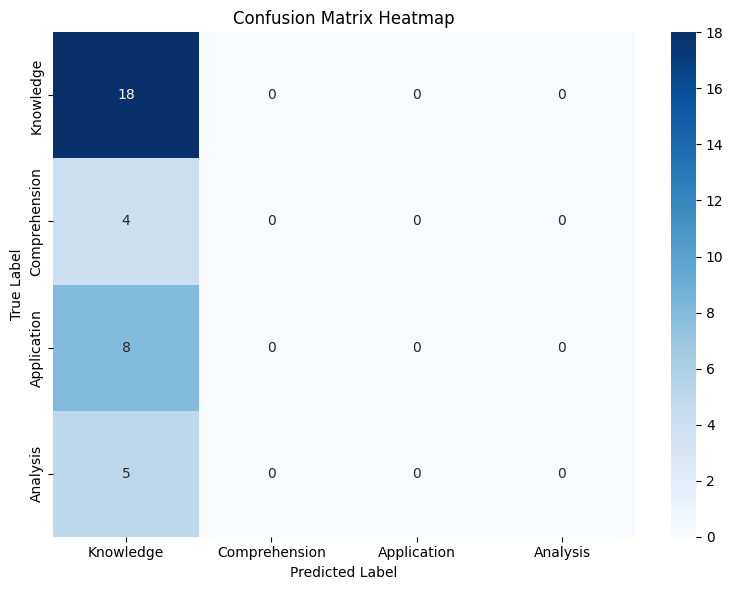

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    conf_matrix,
    annot=True,  # Annotate cells with the counts
    fmt='d',  # Integer format
    cmap='Blues',  # Color map
    xticklabels=bloom_categories,  # Predicted labels
    yticklabels=bloom_categories  # Actual labels
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.tight_layout()
plt.show()


In [11]:
def evaluate(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_data, batch_labels in data_loader:
            # Move batch_data to the same device as the model
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            outputs, _ = model(batch_data) # Get logits from model output
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.tolist())  # Use .tolist() instead of .numpy()
            all_labels.extend(batch_labels.tolist())  # Use .tolist() instead of .numpy()
    return all_preds, all_labels



for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss:.4f}")

# Evaluate on test set
predictions, true_labels = evaluate(model, test_loader)
accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"Test Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Save faulty predictions
faulty_predictions = []
for i, (text, true_label) in enumerate(zip(test_texts, test_labels)):
    predicted_bloom = bloom_categories[predictions[i]]
    actual_bloom = bloom_categories[true_label]

    if predicted_bloom != actual_bloom:
        faulty_predictions.append({
            "question": text,
            "actual_bloom": actual_bloom,
            "predicted_bloom": predicted_bloom
        })

with open(faulty_predictions_path, 'w', encoding='utf-8') as f:
    json.dump(faulty_predictions, f, ensure_ascii=False, indent=4)

print(f"Faulty predictions saved to {faulty_predictions_path}")

Epoch 1/5, Loss: 0.0527
Epoch 2/5, Loss: 0.0493
Epoch 3/5, Loss: 0.0325
Epoch 4/5, Loss: 0.0049
Epoch 5/5, Loss: 0.0029
Test Accuracy: 0.4571, F1 Score: 0.3708
Faulty predictions saved to faulty_predictions.json


Accuracy: 0.4571, F1 Score: 0.3708


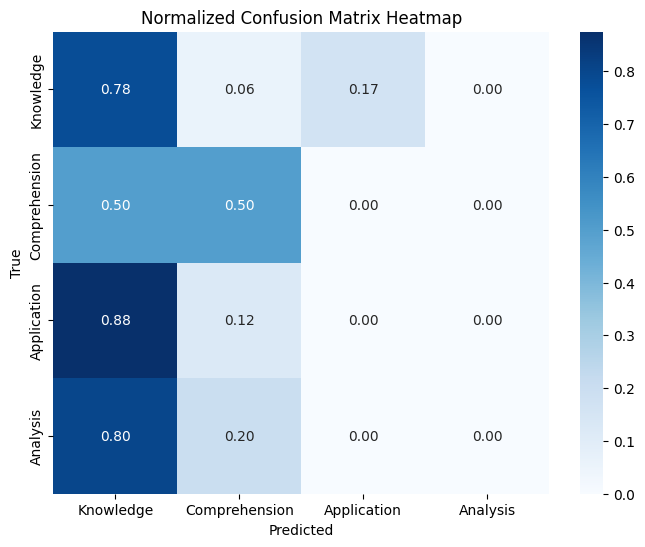

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_heatmap(true_labels, predictions, class_names):
    # Generate the confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Normalize the confusion matrix (optional)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Create the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Normalized Confusion Matrix Heatmap")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Evaluate the model and plot the heatmap
def evaluate_and_plot(model, test_loader, class_names):
    predictions, true_labels = evaluate(model, test_loader)
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average="weighted")

    print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    plot_heatmap(true_labels, predictions, class_names)

# Define class names (example: Bloom taxonomy categories)
class_names = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Call the evaluation and heatmap function
evaluate_and_plot(model, test_loader, class_names)


In [8]:
!pip install numpy

In [2]:
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

# Paths
train_dataset_path = r"eduqg_evaluation_bloom_cleaned.json"
test_dataset_path = r"eduqg_few_shot_bloom_cleaned.json"

# Bloom taxonomy categories
bloom_categories = ["Knowledge", "Comprehension", "Application", "Analysis"]

# Load data
def load_data(dataset_path, bloom_categories):
    texts, labels = [], []
    with open(dataset_path, 'r', encoding='utf-8') as f:
        dataset = json.load(f)
        for chapter in dataset:
            for question_item in chapter.get('questions', []):
                question = question_item.get("question", {}).get("normal_format", "")
                actual_bloom = question_item.get("actual_bloom", "")
                if question and actual_bloom:
                    texts.append(question)
                    labels.append(bloom_categories.index(actual_bloom))
    return texts, labels

train_texts, train_labels = load_data(train_dataset_path, bloom_categories)
test_texts, test_labels = load_data(test_dataset_path, bloom_categories)

# Text vectorization
vectorizer = CountVectorizer(max_features=5000, stop_words="english")
X_train = vectorizer.fit_transform(train_texts).toarray()
X_test = vectorizer.transform(test_texts).toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(test_labels)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Dataset and DataLoader
class TextDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = TextDataset(X_train_tensor, y_train_tensor)
test_dataset = TextDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# Define the GRU model
class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.5):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        gru_out, _ = self.gru(x)
        last_hidden_state = gru_out[:, -1, :]  # Use the last hidden state
        out = self.fc(last_hidden_state)
        return self.softmax(out)

# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 128
output_size = len(bloom_categories)
num_layers = 2
learning_rate = 1e-3
num_epochs = 10

# Initialize the model, loss, and optimizer
model = GRUClassifier(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_data, batch_labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")

# Evaluate the model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch_data, batch_labels in test_loader:
            outputs = model(batch_data)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.numpy())
            all_labels.extend(batch_labels.numpy())
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    print(f"Accuracy: {acc:.4f}, F1 Score: {f1:.4f}")

# Train and evaluate
train_model(model, train_loader, criterion, optimizer, num_epochs)
evaluate_model(model, test_loader)


Epoch 1/10: 100%|██████████| 28/28 [00:00<00:00, 94.44it/s]


Epoch 1, Loss: 36.9167


Epoch 2/10: 100%|██████████| 28/28 [00:00<00:00, 113.26it/s]


Epoch 2, Loss: 29.7005


Epoch 3/10: 100%|██████████| 28/28 [00:00<00:00, 122.48it/s]


Epoch 3, Loss: 28.0631


Epoch 4/10: 100%|██████████| 28/28 [00:00<00:00, 133.64it/s]


Epoch 4, Loss: 28.1475


Epoch 5/10: 100%|██████████| 28/28 [00:00<00:00, 147.90it/s]


Epoch 5, Loss: 27.9084


Epoch 6/10: 100%|██████████| 28/28 [00:00<00:00, 150.01it/s]


Epoch 6, Loss: 27.1210


Epoch 7/10: 100%|██████████| 28/28 [00:00<00:00, 141.69it/s]


Epoch 7, Loss: 26.3257


Epoch 8/10: 100%|██████████| 28/28 [00:00<00:00, 146.65it/s]


Epoch 8, Loss: 26.0348


Epoch 9/10: 100%|██████████| 28/28 [00:00<00:00, 137.45it/s]


Epoch 9, Loss: 25.3324


Epoch 10/10: 100%|██████████| 28/28 [00:00<00:00, 138.45it/s]

Epoch 10, Loss: 24.6941


RuntimeError: Numpy is not available

In [2]:
!pip install torchtext==0.15.1
!pip install torch==2.0.1+cu118 -f https://download.pytorch.org/whl/torch_stable.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu118/torch-2.0.1%2Bcu118-cp311-cp311-linux_x86_64.whl (2267.3 MB)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
                      ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 95, in resolve
    result = self._result = resolver.resolve(
                            ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist